In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import json

In [5]:
# Load dataset
def load_data(train_file, test_file):
    with open(train_file, 'r') as f:
        train_data = json.load(f)
    with open(test_file, 'r') as f:
        test_data = json.load(f)

    X_train = np.array([item['features'] for item in train_data])
    y_train = np.array([item['label'] for item in train_data])
    X_test = np.array([item['features'] for item in test_data])
    y_test = np.array([item['label'] for item in test_data])

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data('spiral_trainset.json', 'spiral_testset.json')

In [125]:
# Plot Gaussian distribution
def plot_gaussian_distribution(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    plt.xlabel('Feature_1')
    plt.ylabel('Feature_2')
    plt.show()

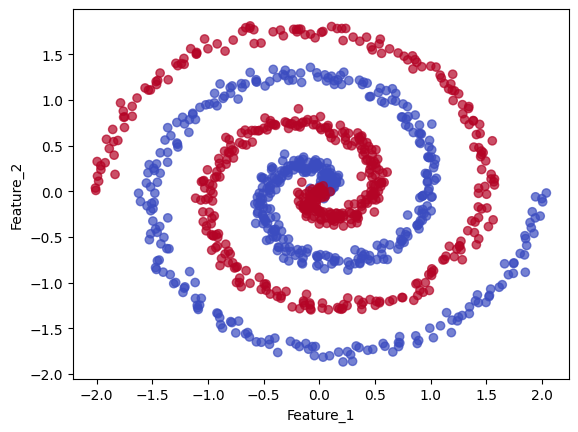

In [126]:
# Trainset distribution
plot_gaussian_distribution(X_train, y_train)

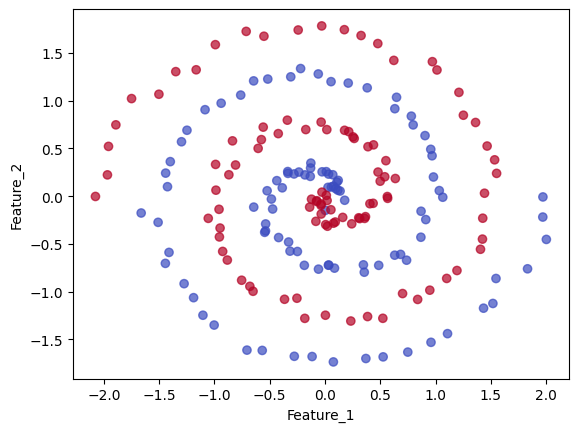

In [127]:
# Testset distribution
plot_gaussian_distribution(X_test, y_test)

In [8]:
# Standardization of Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [129]:
# Design Neural Network
# 1. Gradient Descent

class NeuralNetworkBase_1:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, activation_fn, activation_derivative_fn):
        np.random.seed(42)
        self.weights = []
        self.biases = []
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.activation_derivative_fn = activation_derivative_fn
        layer_dims = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(layer_dims[i], layer_dims[i + 1]) for i in range(len(layer_dims) - 1)]
        self.biases = [np.zeros((1, layer_dims[i + 1])) for i in range(len(layer_dims) - 1)]

    def forward(self, X):
        self.Zs = []
        self.activations = [X]

        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.Zs.append(Z)
            A = self.activation_fn(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.Zs.append(Z)
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = y.shape[0]
        dZ = self.activations[-1] - y.reshape(-1, 1)
        grads_W = []
        grads_b = []

        dW = (1 / m) * np.dot(self.activations[-2].T, dZ)
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        grads_W.insert(0, dW)
        grads_b.insert(0, db)

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivative_fn(self.Zs[i])
            dW = (1 / m) * np.dot(self.activations[i].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
            grads_W.insert(0, dW)
            grads_b.insert(0, db)

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_W[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            self.backward(X, y)
            if i % 1000 == 0:
                loss = self.cal_loss(y, output)
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def cal_loss(self, y, output):
        output = np.clip(output, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

class NeuralNetwork_GD_ReLU(NeuralNetworkBase_1):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, relu, relu_derivative)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

class NeuralNetwork_GD_LeakyReLU(NeuralNetworkBase_1):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, leaky_relu, leaky_relu_derivative)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

class NeuralNetwork_GD_Tanh(NeuralNetworkBase_1):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, tanh, tanh_derivative)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2


In [130]:
# 2. Momentum

class NeuralNetworkBase_2:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, activation_fn, activation_derivative_fn, momentum=0.9):
        np.random.seed(42)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.activation_fn = activation_fn
        self.activation_derivative_fn = activation_derivative_fn

        layer_dims = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(layer_dims[i], layer_dims[i + 1]) for i in range(len(layer_dims) - 1)]
        self.biases = [np.zeros((1, layer_dims[i + 1])) for i in range(len(layer_dims) - 1)]
        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]

    def forward(self, X):
        self.Zs = []
        self.activations = [X]

        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.Zs.append(Z)
            A = self.activation_fn(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.Zs.append(Z)
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = y.shape[0]
        dZ = self.activations[-1] - y.reshape(-1, 1)
        grads_W = []
        grads_b = []

        dW = (1 / m) * np.dot(self.activations[-2].T, dZ)
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        grads_W.insert(0, dW)
        grads_b.insert(0, db)

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivative_fn(self.Zs[i])
            dW = (1 / m) * np.dot(self.activations[i].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
            grads_W.insert(0, dW)
            grads_b.insert(0, db)

        for i in range(len(self.weights)):
            self.velocities_w[i] = self.momentum * self.velocities_w[i] - self.learning_rate * grads_W[i]
            self.velocities_b[i] = self.momentum * self.velocities_b[i] - self.learning_rate * grads_b[i]
            self.weights[i] += self.velocities_w[i]
            self.biases[i] += self.velocities_b[i]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            self.backward(X, y)
            if i % 1000 == 0:
                loss = self.cal_loss(y, output)
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def cal_loss(self, y, output):
        output = np.clip(output, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

class NeuralNetwork_Momentum_ReLU(NeuralNetworkBase_2):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, momentum=0.9):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, relu, relu_derivative, momentum)

class NeuralNetwork_Momentum_LeakyReLU(NeuralNetworkBase_2):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, momentum=0.9):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, leaky_relu, leaky_relu_derivative, momentum)

class NeuralNetwork_Momentum_Tanh(NeuralNetworkBase_2):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, momentum=0.9):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, tanh, tanh_derivative, momentum)


In [131]:
# 3. Adam

class NeuralNetworkBase_3:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, activation_fn, activation_derivative_fn, beta1=0.9, beta2=0.999, epsilon=1e-8):
        np.random.seed(42)
        self.weights = []
        self.biases = []
        self.m_weights = []
        self.v_weights = []
        self.m_biases = []
        self.v_biases = []
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.activation_derivative_fn = activation_derivative_fn
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        layer_dims = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_dims) - 1):
            self.weights.append(np.random.randn(layer_dims[i], layer_dims[i + 1]))
            self.biases.append(np.zeros((1, layer_dims[i + 1])))
            self.m_weights.append(np.zeros_like(self.weights[i]))
            self.v_weights.append(np.zeros_like(self.weights[i]))
            self.m_biases.append(np.zeros_like(self.biases[i]))
            self.v_biases.append(np.zeros_like(self.biases[i]))

    def forward(self, X):
        self.Zs = []
        self.activations = [X]

        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.Zs.append(Z)
            A = self.activation_fn(Z)
            self.activations.append(A)

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.Zs.append(Z)
        A = self.sigmoid(Z)
        self.activations.append(A)
        return A

    def backward(self, X, y):
        m = X.shape[0]
        self.t += 1
        dZ = self.activations[-1] - y.reshape(-1, 1)
        grads_W = []
        grads_b = []

        dW = (1 / m) * np.dot(self.activations[-2].T, dZ)
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        grads_W.insert(0, dW)
        grads_b.insert(0, db)

        for i in reversed(range(len(self.weights) - 1)):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivative_fn(self.Zs[i])
            dW = (1 / m) * np.dot(self.activations[i].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
            grads_W.insert(0, dW)
            grads_b.insert(0, db)

        for i in range(len(self.weights)):
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * grads_W[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (grads_W[i] ** 2)
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * grads_b[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (grads_b[i] ** 2)

            m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
            m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)

            self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, y, iterations):
        for i in range(iterations):
            output = self.forward(X)
            loss = self.calculate_loss(y, output)
            if i % 1000 == 0:
                print(f"Iteration: {i}, Loss: {loss:.4f}")
            self.backward(X, y)

    def calculate_loss(self, y, output):
        output = np.clip(output, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        return loss

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

class NeuralNetwork_Adam_ReLU(NeuralNetworkBase_3):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, relu, relu_derivative, beta1, beta2, epsilon)

class NeuralNetwork_Adam_LeakyReLU(NeuralNetworkBase_3):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, leaky_relu, leaky_relu_derivative, beta1, beta2, epsilon)

class NeuralNetwork_Adam_Tanh(NeuralNetworkBase_3):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate, tanh, tanh_derivative, beta1, beta2, epsilon)


In [6]:
# Grid Search
import itertools

def grid_search(X_train, y_train, X_test, y_test, activation_name, activation_class):
    # Hyperparameter options
    input_size = 2
    output_size = 1
    hidden_layer_options = [[8, 6], [8, 8, 8, 8, 8], [64, 32, 16]]
    learning_rate_options = [0.03, 0.05, 0.1]
    iteration_options = [1000, 1500, 3000]
    best_model = None
    best_accuracy = 0
    best_params = None
    results = []

    print(f"\nGrid Search for {activation_name} Model:\n")
    for hidden_sizes, learning_rate, iterations in itertools.product(
            hidden_layer_options, learning_rate_options, iteration_options):

        try:
            nn = activation_class(input_size, hidden_sizes, output_size, learning_rate)
            nn.train(X_train, y_train, iterations)
            y_pred = nn.forward(X_test)
            y_pred_labels = (y_pred > 0.5).astype(int).flatten()
            accuracy = accuracy_score(y_test, y_pred_labels)

            print(f"Hidden Sizes: {hidden_sizes}, Learning Rate: {learning_rate}, Iterations: {iterations}, Test Accuracy: {accuracy * 100:.2f}%")

            results.append({
                'Model': activation_name,
                'Hidden Sizes': hidden_sizes,
                'Learning Rate': learning_rate,
                'Iterations': iterations,
                'Test Accuracy': accuracy * 100
            })

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (hidden_sizes, learning_rate, iterations)
                best_model = nn

        except Exception as e:
            print(f"Error training {activation_name} with parameters {hidden_sizes}, {learning_rate}, {iterations}: {e}")

    results_df = pd.DataFrame(results)
    results_df.reset_index(drop=True, inplace=True)
    print("\nGrid Search Results:")
    print(results_df)

    if best_params:
        print(f"\nBest Hyperparameters for {activation_name}:")
        print(f"Hidden Sizes: {best_params[0]}, Learning Rate: {best_params[1]}, Iterations: {best_params[2]}, Best Test Accuracy: {best_accuracy * 100:.2f}%")

    return best_model


In [133]:
# Boundary visualization
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    activations = model.forward(grid_points)
    grid_preds = (activations > 0.5).astype(int).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, grid_preds, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, alpha=0.7, linewidth=1.5)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [134]:
best_model_gd_relu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'GD_ReLU', NeuralNetwork_GD_ReLU)


Grid Search for GD_ReLU Model:

Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 68.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.7323
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 67.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.7323
Iteration 2000, Loss: 0.7618
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 67.00%
Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 68.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.7508
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 66.50%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.7508
Iteration 2000, Loss: 0.8017
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 67.50%
Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 67.00%
Iteration 0, Loss: 1.1690
Itera

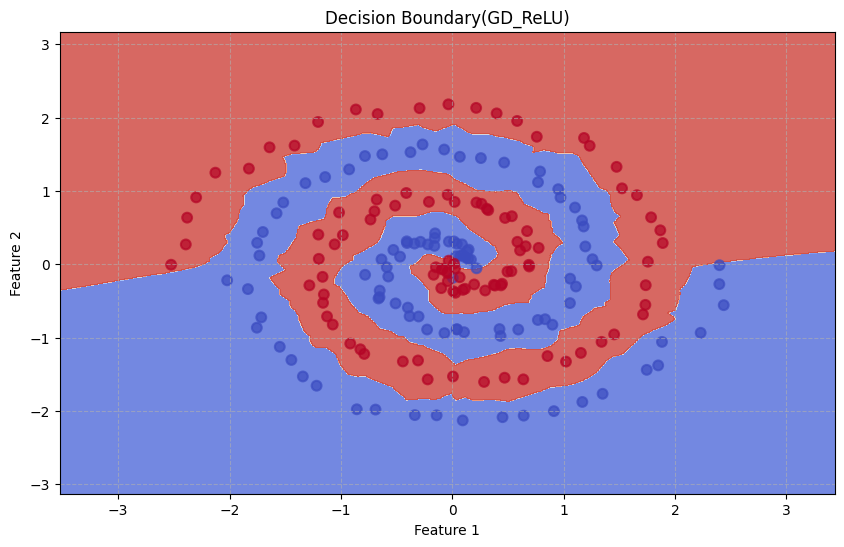

In [135]:
plot_decision_boundary(best_model_gd_relu, X_test_scaled, y_test, title='Decision Boundary(GD_ReLU)')

In [136]:
best_model_gd_leakyrelu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'GD_LeakyReLU', NeuralNetwork_GD_LeakyReLU)


Grid Search for GD_LeakyReLU Model:

Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 65.00%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.7340
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 65.50%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.7340
Iteration 2000, Loss: 0.7656
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 64.00%
Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 65.50%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.7552
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 65.50%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.7552
Iteration 2000, Loss: 0.7989
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 63.50%
Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 64.00%
Iteration 0, Loss: 1.1646


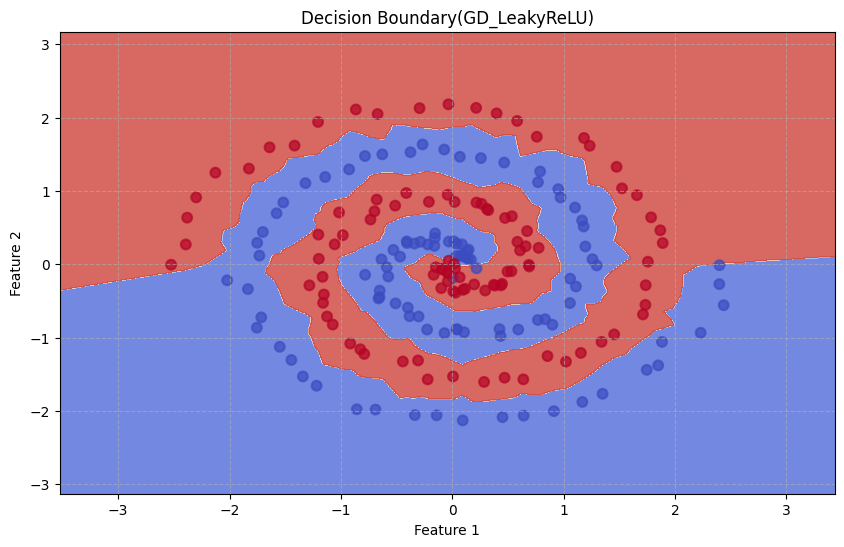

In [137]:
plot_decision_boundary(best_model_gd_leakyrelu, X_test_scaled, y_test, title='Decision Boundary(GD_LeakyReLU)')

In [138]:
best_model_gd_tanh = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'GD_Tanh', NeuralNetwork_GD_Tanh)


Grid Search for GD_Tanh Model:

Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 64.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.7308
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 63.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.7308
Iteration 2000, Loss: 0.7472
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 62.50%
Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 63.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.7426
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 62.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.7426
Iteration 2000, Loss: 0.7633
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 64.00%
Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 62.00%
Iteration 0, Loss: 0.7176
Itera

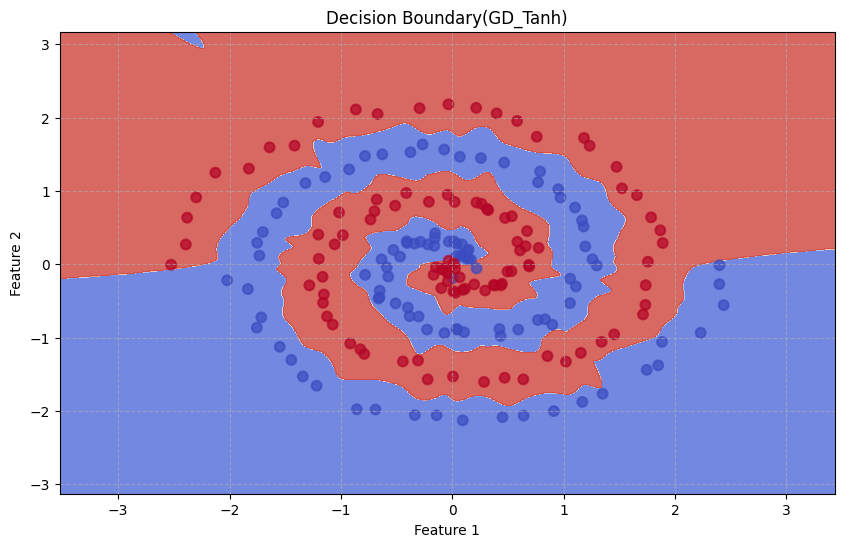

In [139]:
plot_decision_boundary(best_model_gd_tanh, X_test_scaled, y_test, title='Decision Boundary(GD_Tanh)')

In [140]:
best_model_momentum_relu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Momentum_ReLU', NeuralNetwork_Momentum_ReLU)


Grid Search for Momentum_ReLU Model:

Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 73.50%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.9220
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 87.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 0.9220
Iteration 2000, Loss: 1.9632
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 89.50%
Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 89.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 1.5353
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 89.00%
Iteration 0, Loss: 1.1690
Iteration 1000, Loss: 1.5353
Iteration 2000, Loss: 2.3894
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 97.50%
Iteration 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 86.00%
Iteration 0, Loss: 1.1690

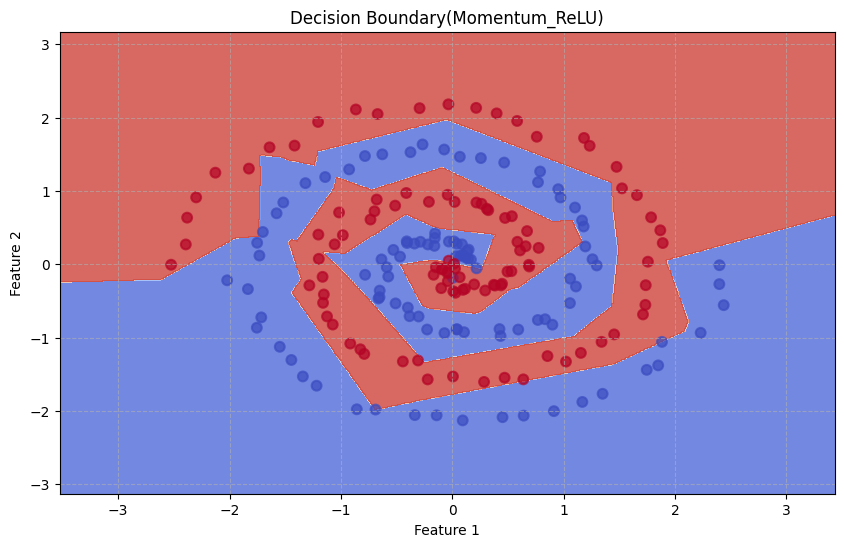

In [141]:
plot_decision_boundary(best_model_momentum_relu, X_test_scaled, y_test, title='Decision Boundary(Momentum_ReLU)')

In [142]:
best_model_momentum_leakyrelu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Momentum_LeakyReLU', NeuralNetwork_Momentum_LeakyReLU)


Grid Search for Momentum_LeakyReLU Model:

Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 66.50%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.8730
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 85.50%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 0.8730
Iteration 2000, Loss: 1.6997
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 96.50%
Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 83.00%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 1.4138
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 89.00%
Iteration 0, Loss: 1.1646
Iteration 1000, Loss: 1.4138
Iteration 2000, Loss: 2.4876
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 97.00%
Iteration 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 89.00%
Iteration 0, Loss: 1

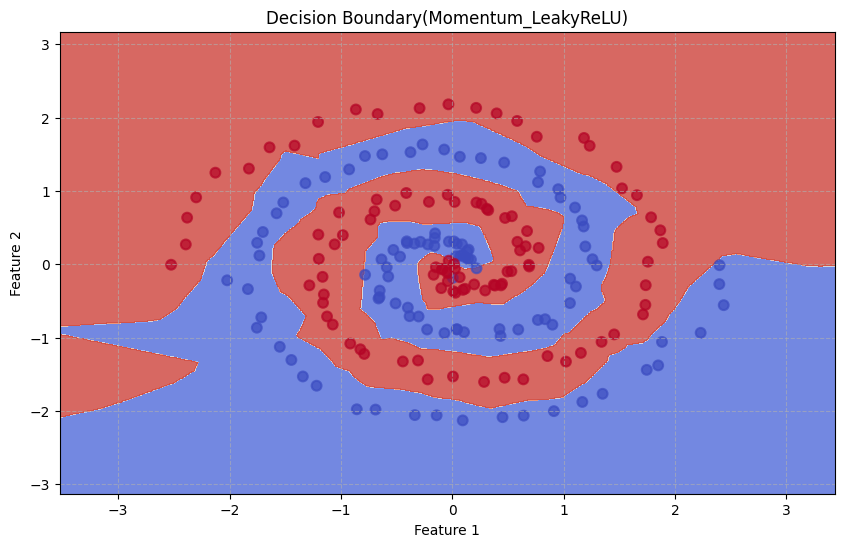

In [143]:
plot_decision_boundary(best_model_momentum_leakyrelu, X_test_scaled, y_test, title='Decision Boundary(Momentum_LeakyReLU)')

In [144]:
best_model_momentum_tanh = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Momentum_Tanh', NeuralNetwork_Momentum_Tanh)


Grid Search for Momentum_Tanh Model:

Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 71.50%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.8477
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 72.50%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.8477
Iteration 2000, Loss: 0.9621
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 83.00%
Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 74.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.9160
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 82.00%
Iteration 0, Loss: 0.7176
Iteration 1000, Loss: 0.9160
Iteration 2000, Loss: 1.2282
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 94.00%
Iteration 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 87.50%
Iteration 0, Loss: 0.7176

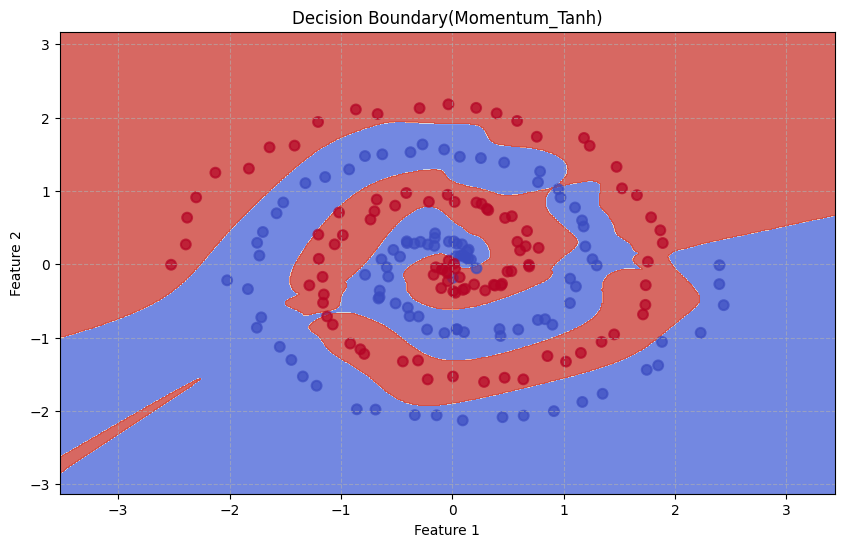

In [145]:
plot_decision_boundary(best_model_momentum_tanh, X_test_scaled, y_test, title='Decision Boundary(Momentum_Tanh)')

In [146]:
best_model_adam_relu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Adam_ReLU', NeuralNetwork_Adam_ReLU)


Grid Search for Adam_ReLU Model:

Iteration: 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 89.00%
Iteration: 0, Loss: 1.1690
Iteration: 1000, Loss: 2.2852
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 91.50%
Iteration: 0, Loss: 1.1690
Iteration: 1000, Loss: 2.2852
Iteration: 2000, Loss: 3.4458
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 92.50%
Iteration: 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 92.00%
Iteration: 0, Loss: 1.1690
Iteration: 1000, Loss: 2.9531
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 93.50%
Iteration: 0, Loss: 1.1690
Iteration: 1000, Loss: 2.9531
Iteration: 2000, Loss: 3.1617
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 91.00%
Iteration: 0, Loss: 1.1690
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 86.00%
Iteration: 0, Lo

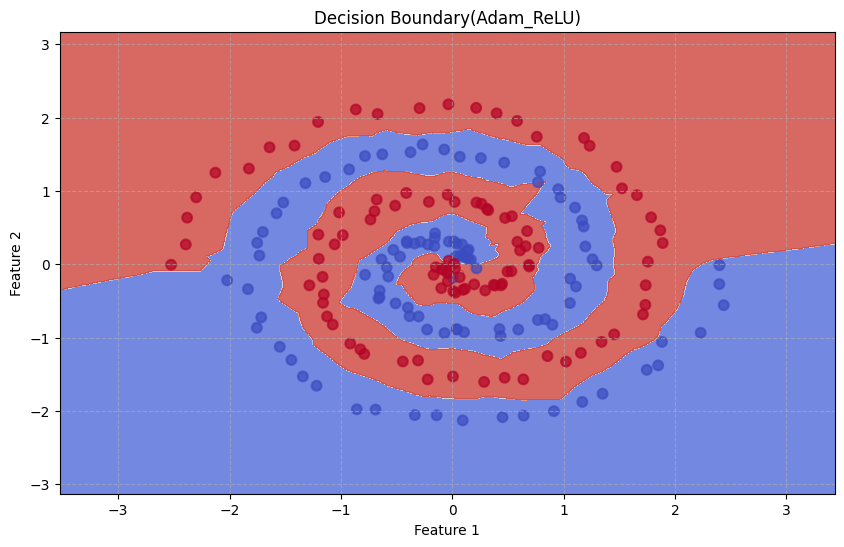

In [147]:
plot_decision_boundary(best_model_adam_relu, X_test_scaled, y_test, title='Decision Boundary(Adam_ReLU)')

In [148]:
best_model_adam_leakyrelu = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Adam_LeakyReLU', NeuralNetwork_Adam_LeakyReLU)


Grid Search for Adam_LeakyReLU Model:

Iteration: 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 93.50%
Iteration: 0, Loss: 1.1646
Iteration: 1000, Loss: 2.8255
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 97.00%
Iteration: 0, Loss: 1.1646
Iteration: 1000, Loss: 2.8255
Iteration: 2000, Loss: 3.7625
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 98.50%
Iteration: 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 88.50%
Iteration: 0, Loss: 1.1646
Iteration: 1000, Loss: 3.2654
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 90.50%
Iteration: 0, Loss: 1.1646
Iteration: 1000, Loss: 3.2654
Iteration: 2000, Loss: 3.9766
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 93.50%
Iteration: 0, Loss: 1.1646
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 89.00%
Iteration: 

<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration: 2000, Loss: 2.7595
Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 97.00%
Iteration: 0, Loss: 5.4862
Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 61.50%
Iteration: 0, Loss: 5.4862
Iteration: 1000, Loss: 1.2376


<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 60.50%
Iteration: 0, Loss: 5.4862
Iteration: 1000, Loss: 1.2376


<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration: 2000, Loss: 2.0883
Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 77.00%
Iteration: 0, Loss: 5.4862


<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 57.00%
Iteration: 0, Loss: 5.4862


<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration: 1000, Loss: 1.3908
Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.1, Iterations: 1500, Test Accuracy: 55.50%
Iteration: 0, Loss: 5.4862


<ipython-input-131-f51e694607cc>:80: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration: 1000, Loss: 1.3908
Iteration: 2000, Loss: 1.1553
Hidden Sizes: [8, 8, 8, 8, 8], Learning Rate: 0.1, Iterations: 3000, Test Accuracy: 56.00%
Iteration: 0, Loss: 11.1704
Hidden Sizes: [64, 32, 16], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 98.50%
Iteration: 0, Loss: 11.1704
Iteration: 1000, Loss: 5.0719
Hidden Sizes: [64, 32, 16], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 99.00%
Iteration: 0, Loss: 11.1704
Iteration: 1000, Loss: 5.0719
Iteration: 2000, Loss: 6.0234
Hidden Sizes: [64, 32, 16], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 98.00%
Iteration: 0, Loss: 11.1704
Hidden Sizes: [64, 32, 16], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 98.50%
Iteration: 0, Loss: 11.1704
Iteration: 1000, Loss: 4.6758
Hidden Sizes: [64, 32, 16], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 98.00%
Iteration: 0, Loss: 11.1704
Iteration: 1000, Loss: 4.6758
Iteration: 2000, Loss: 5.6108
Hidden Sizes: [64, 32, 16], Learning Rate: 0.05, Iterati

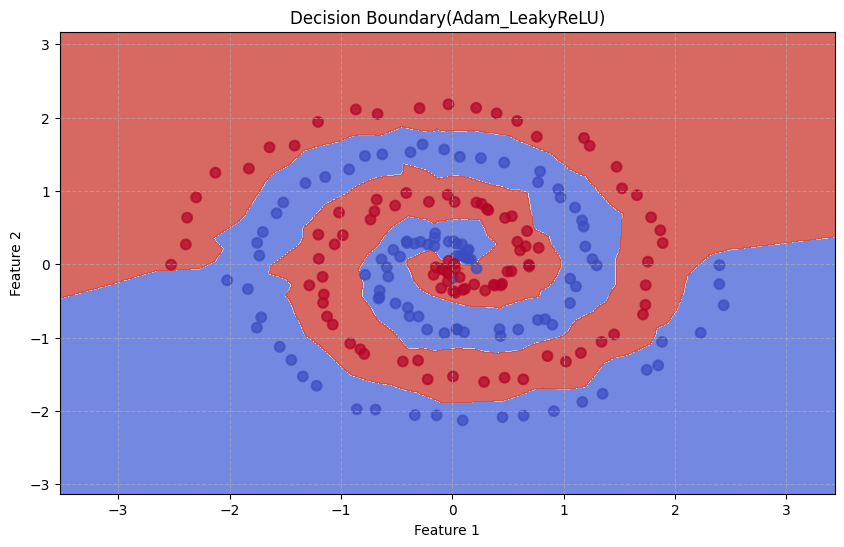

In [149]:
plot_decision_boundary(best_model_adam_leakyrelu, X_test_scaled, y_test, title='Decision Boundary(Adam_LeakyReLU)')

In [150]:
best_model_adam_tanh = grid_search(X_train_scaled, y_train, X_test_scaled, y_test, 'Adam_Tanh', NeuralNetwork_Adam_Tanh)


Grid Search for Adam_Tanh Model:

Iteration: 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 98.00%
Iteration: 0, Loss: 0.7176
Iteration: 1000, Loss: 3.4940
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 97.50%
Iteration: 0, Loss: 0.7176
Iteration: 1000, Loss: 3.4940
Iteration: 2000, Loss: 4.3792
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 98.00%
Iteration: 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 98.50%
Iteration: 0, Loss: 0.7176
Iteration: 1000, Loss: 3.8726
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 98.00%
Iteration: 0, Loss: 0.7176
Iteration: 1000, Loss: 3.8726
Iteration: 2000, Loss: 4.6916
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 98.00%
Iteration: 0, Loss: 0.7176
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 96.00%
Iteration: 0, Lo

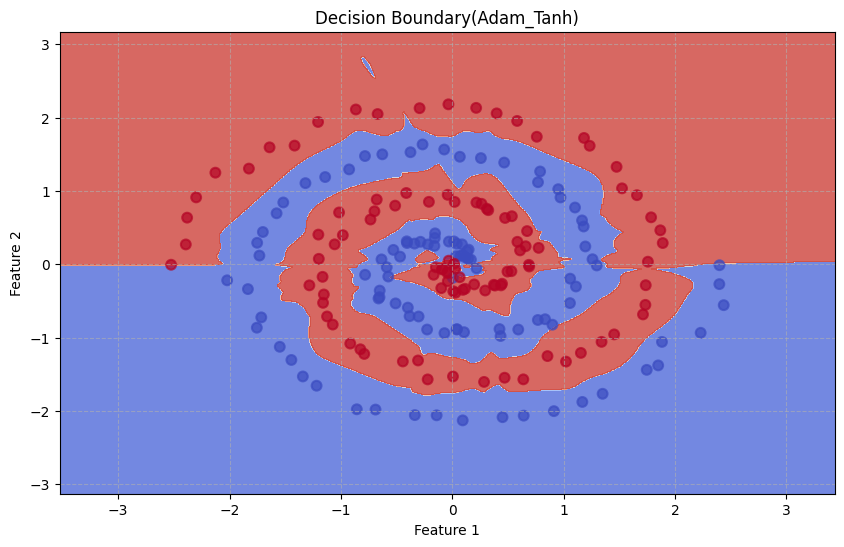

In [151]:
plot_decision_boundary(best_model_adam_tanh, X_test_scaled, y_test, title='Decision Boundary(Adam_Tanh)')

In [152]:
# Convert cartesian to polar
def cartesian_to_polar(X):
    r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
    theta = np.arctan2(X[:, 1], X[:, 0])
    return np.column_stack((r, theta))

In [153]:
# Apply polar
X_train_polar = cartesian_to_polar(X_train)
X_test_polar = cartesian_to_polar(X_test)

X_train_polar_scaled = scaler.fit_transform(X_train_polar)
X_test_polar_scaled = scaler.transform(X_test_polar)

In [154]:
best_model_gd_relu_polar = grid_search(X_train_polar_scaled, y_train, X_test_polar_scaled, y_test, 'GD_ReLU_Polar', NeuralNetwork_GD_ReLU)


Grid Search for GD_ReLU_Polar Model:

Iteration 0, Loss: 1.2118
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1000, Test Accuracy: 82.00%
Iteration 0, Loss: 1.2118
Iteration 1000, Loss: 0.9067
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 1500, Test Accuracy: 84.00%
Iteration 0, Loss: 1.2118
Iteration 1000, Loss: 0.9067
Iteration 2000, Loss: 1.2175
Hidden Sizes: [8, 6], Learning Rate: 0.03, Iterations: 3000, Test Accuracy: 85.50%
Iteration 0, Loss: 1.2118
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1000, Test Accuracy: 84.50%
Iteration 0, Loss: 1.2118
Iteration 1000, Loss: 1.1253
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 1500, Test Accuracy: 85.00%
Iteration 0, Loss: 1.2118
Iteration 1000, Loss: 1.1253
Iteration 2000, Loss: 1.5316
Hidden Sizes: [8, 6], Learning Rate: 0.05, Iterations: 3000, Test Accuracy: 89.00%
Iteration 0, Loss: 1.2118
Hidden Sizes: [8, 6], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 86.00%
Iteration 0, Loss: 1.2118

<ipython-input-129-94eb3d2cc567>:56: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Hidden Sizes: [64, 32, 16], Learning Rate: 0.1, Iterations: 1000, Test Accuracy: 97.50%
Iteration 0, Loss: 11.4070


<ipython-input-129-94eb3d2cc567>:56: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration 1000, Loss: 3.5598
Hidden Sizes: [64, 32, 16], Learning Rate: 0.1, Iterations: 1500, Test Accuracy: 97.50%
Iteration 0, Loss: 11.4070


<ipython-input-129-94eb3d2cc567>:56: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration 1000, Loss: 3.5598
Iteration 2000, Loss: 4.3515
Hidden Sizes: [64, 32, 16], Learning Rate: 0.1, Iterations: 3000, Test Accuracy: 98.00%

Grid Search Results:
            Model     Hidden Sizes  Learning Rate  Iterations  Test Accuracy
0   GD_ReLU_Polar           [8, 6]           0.03        1000           82.0
1   GD_ReLU_Polar           [8, 6]           0.03        1500           84.0
2   GD_ReLU_Polar           [8, 6]           0.03        3000           85.5
3   GD_ReLU_Polar           [8, 6]           0.05        1000           84.5
4   GD_ReLU_Polar           [8, 6]           0.05        1500           85.0
5   GD_ReLU_Polar           [8, 6]           0.05        3000           89.0
6   GD_ReLU_Polar           [8, 6]           0.10        1000           86.0
7   GD_ReLU_Polar           [8, 6]           0.10        1500           89.0
8   GD_ReLU_Polar           [8, 6]           0.10        3000           97.0
9   GD_ReLU_Polar  [8, 8, 8, 8, 8]           0.03        1000 

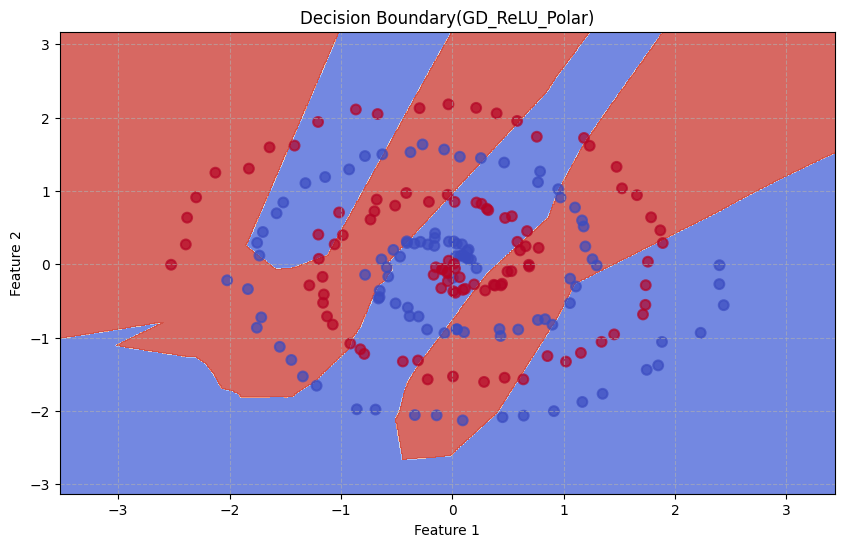

In [155]:
plot_decision_boundary(best_model_gd_relu_polar, X_test_scaled, y_test, title='Decision Boundary(GD_ReLU_Polar)')